In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import json
import pandas as pd
import numpy as np
import operator
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem.snowball import SnowballStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score
from sklearn.metrics import hamming_loss
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import MultinomialNB
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.problem_transform import LabelPowerset

stemmer = SnowballStemmer("english")

pd.options.display.max_colwidth = 200

In [2]:
df = pd.read_csv(".\DATASETS\EJOR_DATABASE_ABSTRACT_KEYWORDS_UPDATED.csv") #all 19k papers, changed desired path, with updates
df = df[df['Year'] <= 2023]
df['Category'] = df['Text'].apply(lambda x: "Maintenance" if stemmer.stem("maintenance") in x else "Non-Maintenance")
df['YearDiff'] = 2024 - df['Year']
df['CitedByYear'] = df['Cited by'] / df['YearDiff']

contain_values_M = df[(df['Text'].str.contains(stemmer.stem('maintenance')))]
contain_values_M = contain_values_M.reset_index(drop=True)

# Table of contents

## 1. General Analysis
### 1.1 Trend Analysis
### 1.2 Fraction of papers about Maintenance
### 1.3 Citations
### 1.4 Authors
## 2. Interfaces

## 1. General Analysis

### 1.1 Trend analysis ###

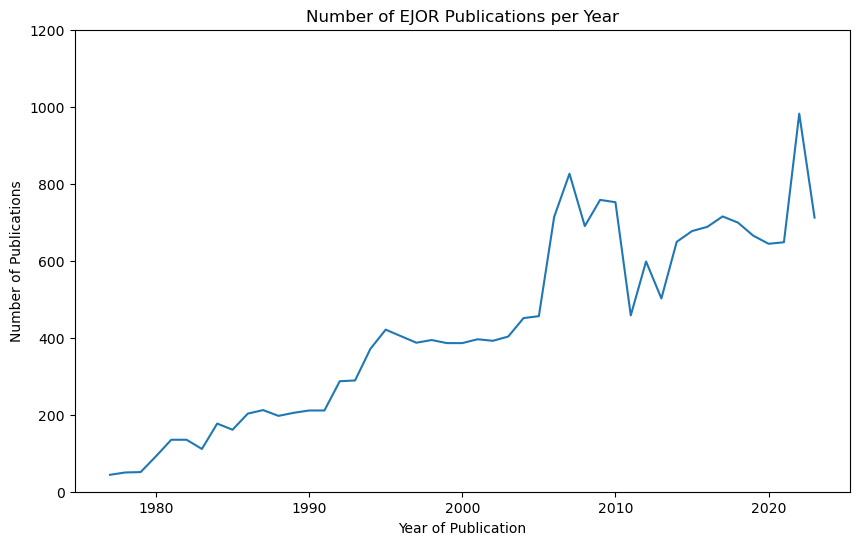

In [18]:
#All papers

years_count = df.groupby("Year")['Year'].count().reset_index(name="Count")

plt.figure(figsize = (10,6))

sns.lineplot(x = 'Year', y = "Count", data = years_count)

plt.xlabel("Year of Publication")

plt.ylabel("Number of Publications")

plt.title("Number of EJOR Publications per Year")
plt.ylim(0,1200)

plt.show()

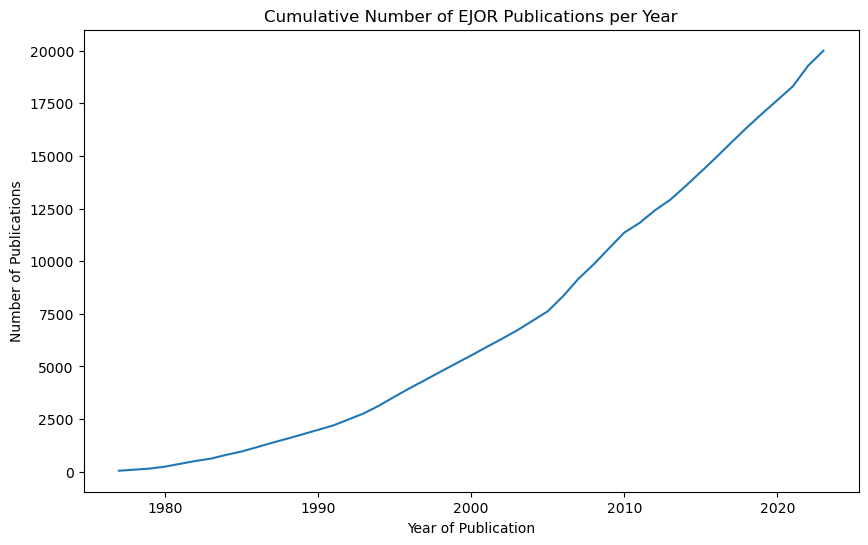

In [19]:
#All papers cumul

years_count_cumsum = df.groupby("Year")['Year'].count().cumsum().reset_index(name="Count")

plt.figure(figsize = (10,6))

sns.lineplot(x = 'Year', y = "Count", data = years_count_cumsum)

plt.xlabel("Year of Publication")

plt.ylabel("Number of Publications")

plt.title("Cumulative Number of EJOR Publications per Year")
#plt.ylim(0,900)

plt.show()

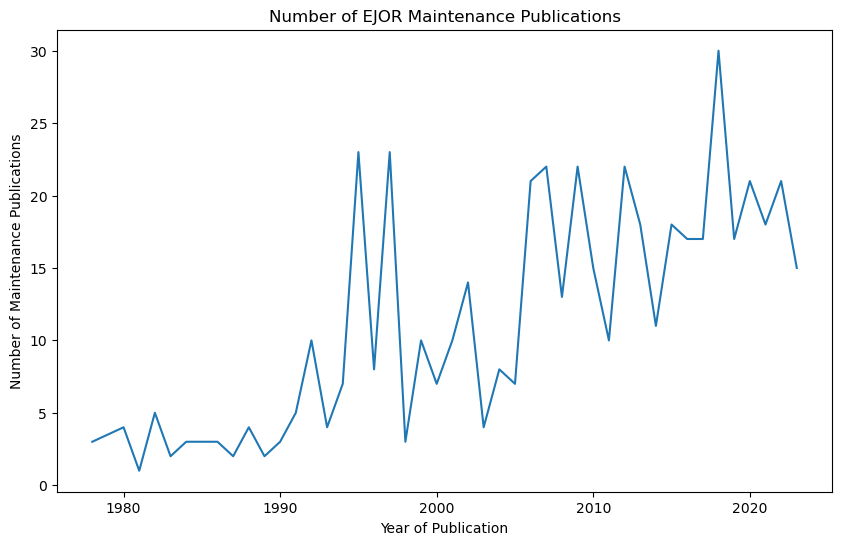

In [20]:
#Maintenance papers

years_count_M = contain_values_M.groupby("Year")['Year'].count().reset_index(name="Count")

plt.figure(figsize = (10,6))

sns.lineplot(x = 'Year', y = "Count", data = years_count_M)

plt.xlabel("Year of Publication")

plt.ylabel("Number of Maintenance Publications")

plt.title("Number of EJOR Maintenance Publications")

#plt.ylim(0,900)
plt.show()

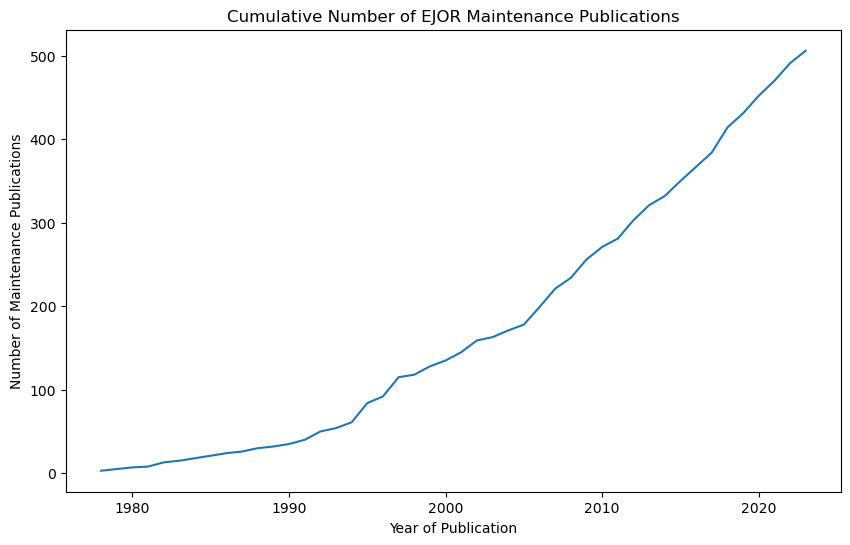

In [21]:
#Maintenance Papers Cumul

years_count_M = contain_values_M.groupby("Year")['Year'].count().cumsum().reset_index(name="Count")

plt.figure(figsize = (10,6))

sns.lineplot(x = 'Year', y = "Count", data = years_count_M)

plt.xlabel("Year of Publication")

plt.ylabel("Number of Maintenance Publications")

plt.title("Cumulative Number of EJOR Maintenance Publications")

plt.show()

### 1.2 Fraction of papers about Maintenance ###

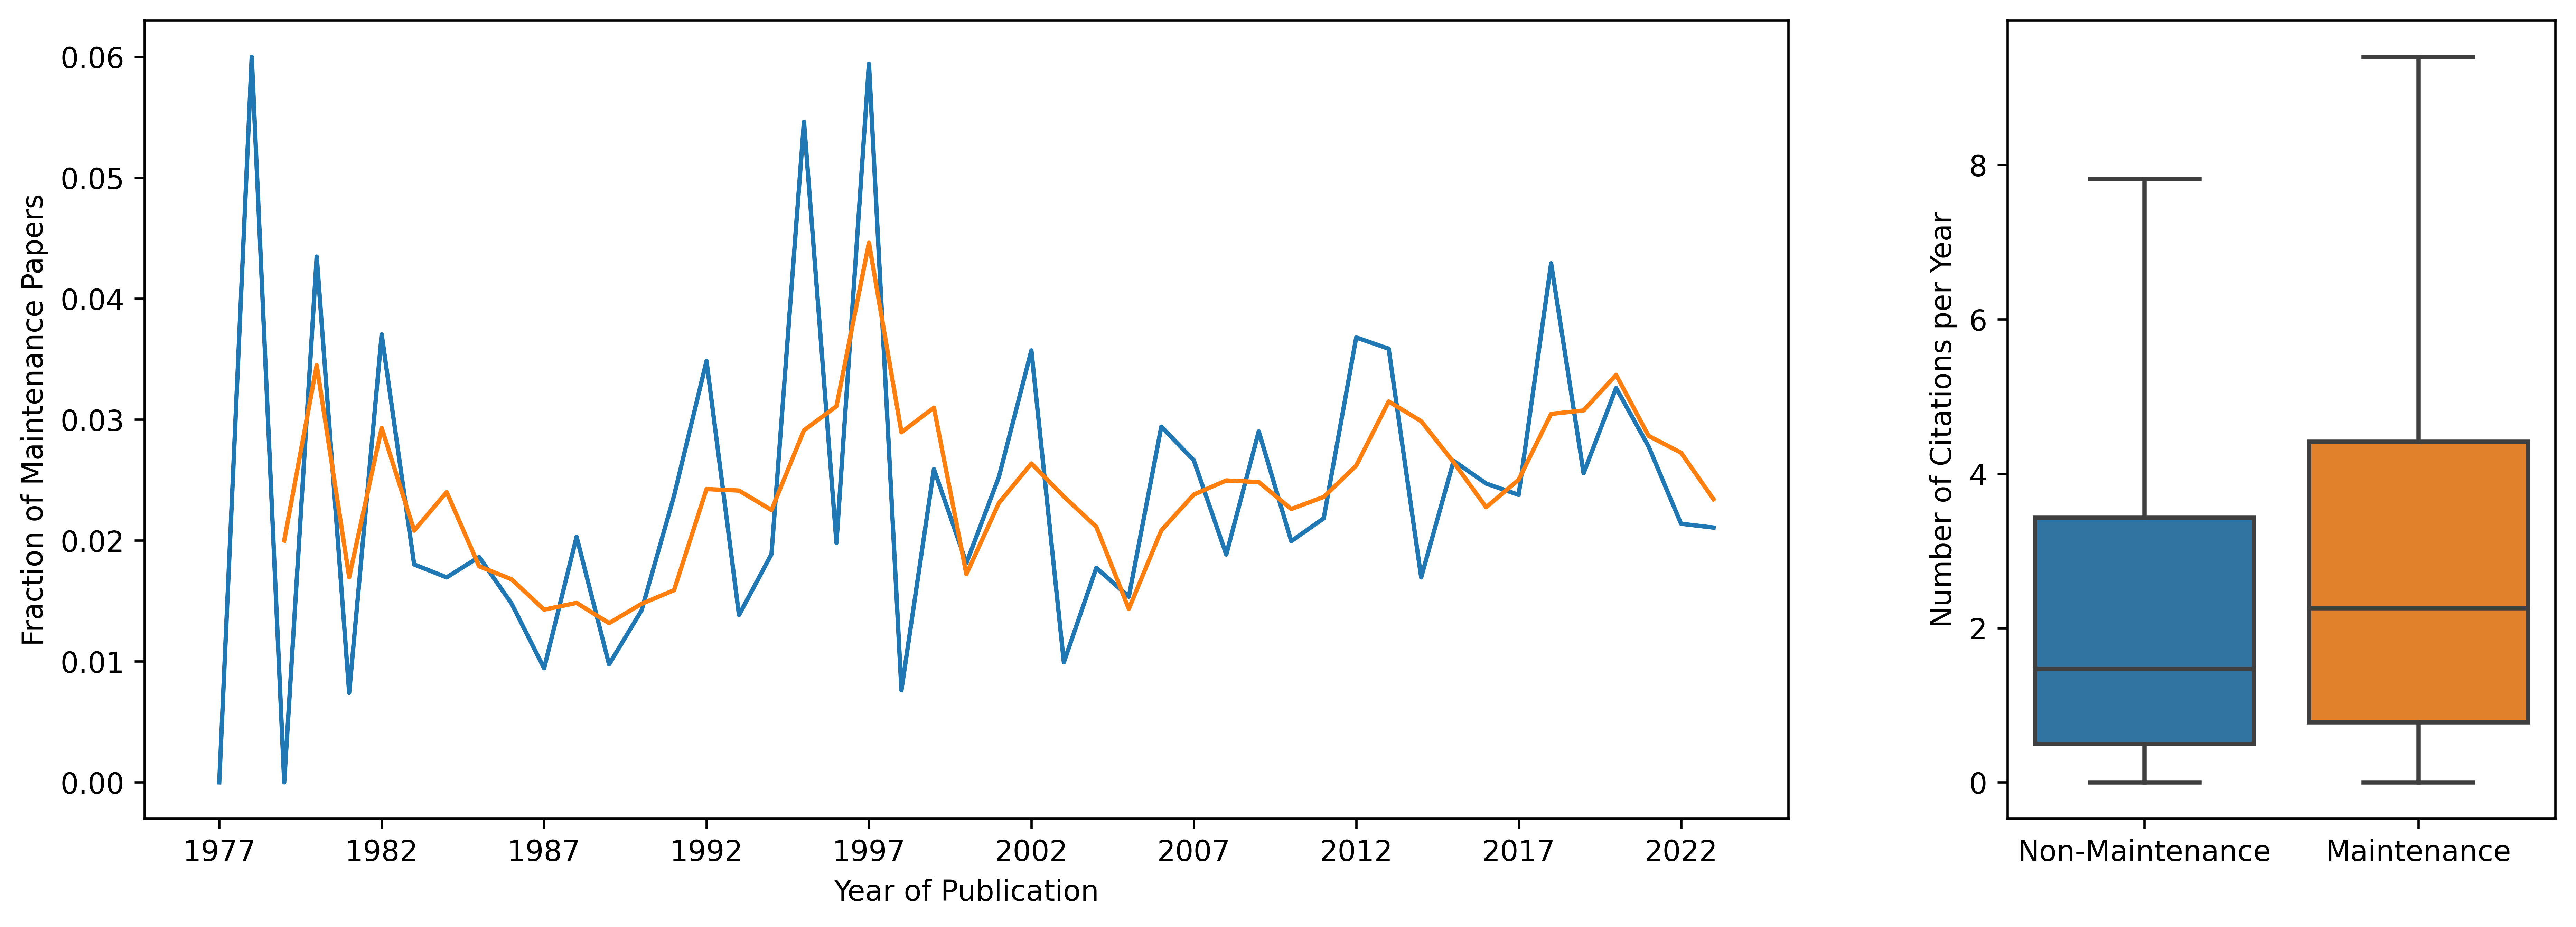

In [22]:
#fraction of maintenance papers

k = 3
f, (ax1, ax2) = plt.subplots(1,2, figsize = (15,5), dpi = 600, gridspec_kw={'width_ratios': [3, 1]})
plt.rcParams.update({'font.size': 10})

#data
maintenance_fraction = contain_values_M.groupby("Year")['Year'].count() / df.groupby("Year")['Year'].count()
maintenance_fraction = maintenance_fraction.fillna(0)
maintenance_fraction = maintenance_fraction.reset_index(name="MaintenanceFraction")
maintenance_fraction['Smoothed_Avg'] = maintenance_fraction['MaintenanceFraction'].rolling(window=k).mean()
#enddata

#plt.figure(figsize=(7, 5x), dpi = 300)

#fraction
sns.lineplot(x="Year",y="MaintenanceFraction", data= maintenance_fraction, ax = ax1)
sns.lineplot(x="Year", y="Smoothed_Avg", data=maintenance_fraction, ax = ax1)

ax1.set_xlabel("Year of Publication")
ax1.set_xticks(range(1977,2023,5))

ax1.set_ylabel("Fraction of Maintenance Papers")


#citations

sns.boxplot(x="Category", y = "CitedByYear", data = df, showfliers = False, orient='v', ax = ax2)
ax2.set_ylabel("Number of Citations per Year")
ax2.set_xlabel("")


#plt.title("Fraction of EJOR Papers on Maintenance")

plt.savefig(".\Graphs\maintfractandcitations.jpg", format='jpeg', bbox_inches='tight')
plt.show()

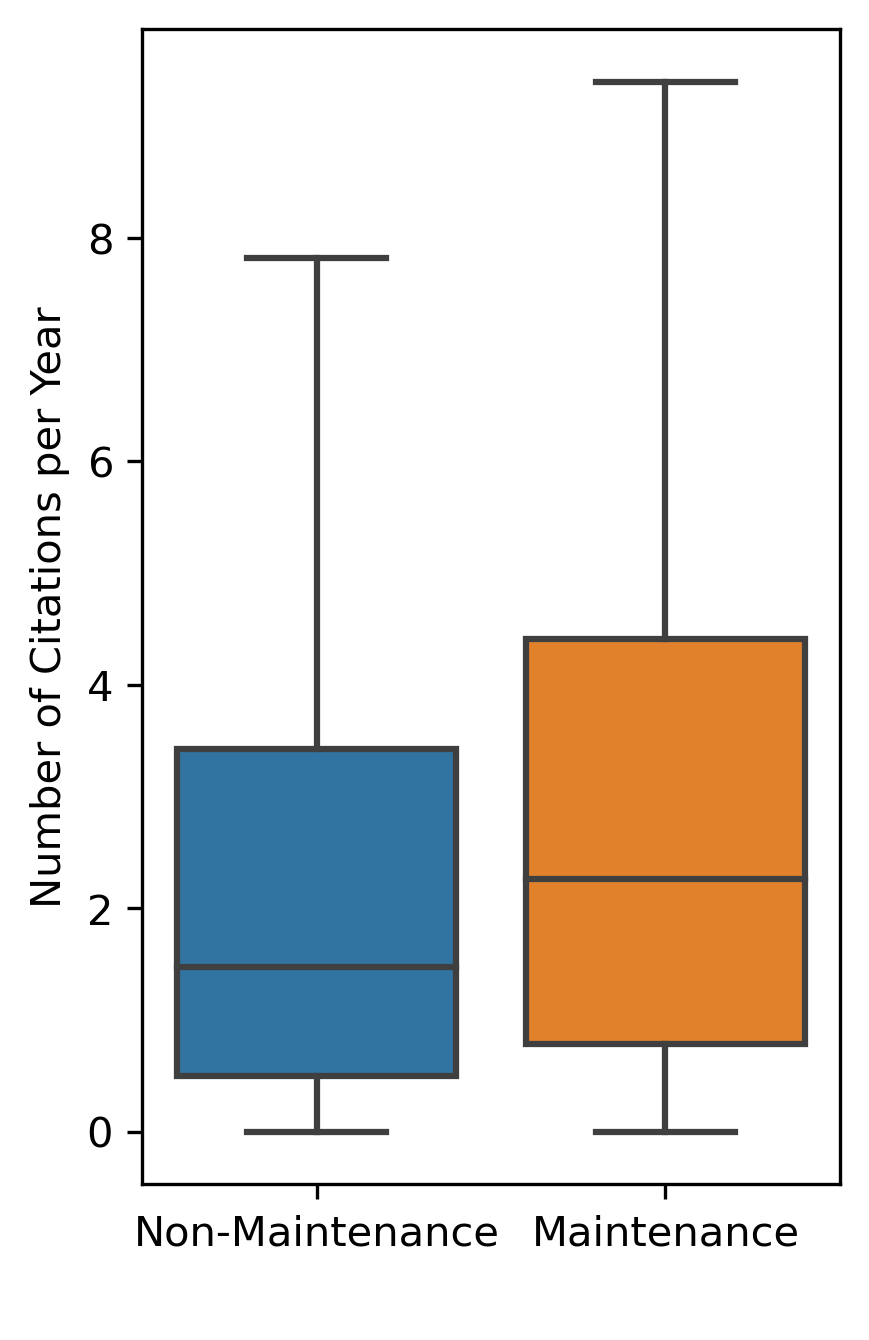

In [23]:
plt.figure(figsize=(3, 5), dpi = 300)

sns.boxplot(x="Category", y = "CitedByYear", data = df, showfliers = False, orient='v')

plt.rcParams.update({'font.size': 10})
plt.ylabel("Number of Citations per Year")
plt.xlabel(" ")


plt.savefig(".\Graphs\MaintenanceCitedBox.jpg", format='jpeg', bbox_inches='tight')
plt.show()

### 1.3 Citations ####

In [24]:
qlist = []
qall = []
qm = []

for i in np.arange(0.1,1.1,0.1):
    qlist.append(str(round(i * 100)) + "th")
    qall.append(df['Cited by'].quantile(i))
    qm.append(contain_values_M['Cited by'].quantile(i))
quantdf = pd.DataFrame({"Quantile": qlist, "All Papers": qall, "Maintenance Papers": qm})
quantdf['ratio'] = quantdf['Maintenance Papers'] / quantdf['All Papers']
quantdf

,Quantile,All Papers,Maintenance Papers,ratio
0,10th,1.0,3.0,3.000000
1,20th,4.0,7.0,1.750000
2,30th,8.0,13.0,1.625000
3,40th,12.0,18.0,1.500000
4,50th,18.0,24.0,1.333333
5,60th,25.0,35.0,1.400000
6,70th,36.0,49.0,1.361111
7,80th,55.0,67.0,1.218182
8,90th,94.0,102.0,1.085106
9,100th,18616.0,1449.0,0.077836


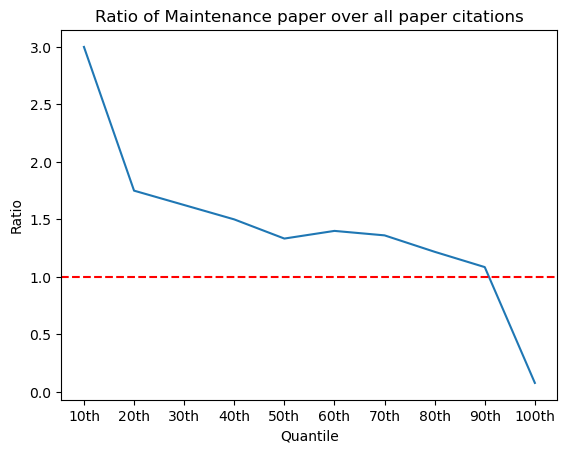

In [25]:
sns.lineplot(x="Quantile", y="ratio", data = quantdf)

ax = plt.gca()
ax.axhline(y=1, color='red', linestyle='--', label='y = 1')

plt.xlabel("Quantile")
plt.ylabel("Ratio")
plt.title("Ratio of Maintenance paper over all paper citations")

plt.show()

In [26]:
#test for significance 

from scipy import stats

OtherPapers = df[df['Category'] == "Non-Maintenance"]['CitedByYear'].to_numpy()
MaintenancePapers = df[df['Category'] == "Maintenance"]['CitedByYear'].to_numpy()

t_statistic, p_value = stats.ttest_ind(OtherPapers, MaintenancePapers)

print("T-statistic:", t_statistic)
print("P-value:", p_value)

T-statistic: -2.5192703833156775
P-value: 0.01176756267351808


In [29]:
MaintenancePapers.mean()

3.7599671401132753

In [27]:
OtherPapers.mean()

3.032787665977987

In [28]:
df[df['Category'] == "Maintenance"].sort_values("Cited by",ascending=False).head(20).to_csv("top20Maintenance.csv",index=False)

### 1.4 Authors ###

In [4]:
#Most cited authors in maintenance
from pybliometrics.scopus import AuthorRetrieval

df['Author(s) ID'] = df['Author(s) ID'].replace('[No author name available]', '0')
df['AuthorsIDClean'] = df['Author(s) ID'].str.split(";").map(lambda x: [int(i) for i in x])
authordf = df.explode("AuthorsIDClean")
grouped_count = authordf.groupby("AuthorsIDClean", as_index=False)['Cited by'].sum()
grouped_count = grouped_count.sort_values(by="Cited by", ascending = False).reset_index()

top500 = grouped_count.head(500)

top500['name_author'] = top500['AuthorsIDClean'].apply(lambda x: AuthorRetrieval(x).indexed_name)

C:\Users\u0156959\AppData\Local\Temp\ipykernel_15720\1912107919.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top500['name_author'] = top500['AuthorsIDClean'].apply(lambda x: AuthorRetrieval(x).indexed_name)


## 2. Interfaces ##

## 2.1 Spare parts and inventory 

In [34]:
keyword1 = "spare parts"
keyword2 = "inventory"
keyword3 = "forecasting"
keyword4 = "stocking"

check1 = contain_values_M['Text'].str.contains(stemmer.stem(keyword1))
check2 = contain_values_M['Text'].str.contains(stemmer.stem(keyword2))
check3 = contain_values_M['Text'].str.contains(stemmer.stem(keyword3))
check4 = contain_values_M['Text'].str.contains(stemmer.stem(keyword4))


sif = contain_values_M[check1 | check2 | check4]
sif.to_excel(".\Interfaces\SpareParts.xlsx")
sif.count()

Unnamed: 0     54
Year           54
Cited by       54
DOI            54
Title          54
Text           54
Category       54
YearDiff       54
CitedByYear    54
dtype: int64

## 2.2 Production and maintenance

In [16]:
RevenueInMaintenance = contain_values_M[(contain_values_M['Text'].str.contains(stemmer.stem("revenue")))]
RevenueInMaintenance

In [14]:
ProductRateInMaintenance = contain_values_M[(contain_values_M['Text'].str.contains("product rate"))]
ProductRateInMaintenance

In [37]:
ProductInMaintenance = contain_values_M[(contain_values_M['Text'].str.contains(stemmer.stem("production")))]
ProductInMaintenance.to_excel(".\Interfaces\Production.xlsx")

## 2.3 Design for maintenance

In [39]:
DesignInMaintenance = contain_values_M[(contain_values_M['Text'].str.contains(stemmer.stem("design")))]
DesignInMaintenance.to_excel(".\Interfaces\DesignMaintenance.xlsx")

In [38]:
RedundancyReliability = df[(df['Text'].str.contains(stemmer.stem("redundancy"))) & (df['Text'].str.contains(stemmer.stem("reliability")))]
RedundancyReliability.to_excel(".\Interfaces\RedundancyReliability.xlsx")

## 2.4 resource constraints

In [41]:
CapacityMaintenance = contain_values_M[(contain_values_M['Text'].str.contains(stemmer.stem("capacity")))]
CapacityMaintenance.to_excel(".\Interfaces\Capacity.xlsx")

In [40]:
MachineRepair = df[(df['Text'].str.contains(stemmer.stem("machin repair ")))]
MachineRepair.to_excel(".\Interfaces\Repair.xlsx")

## 2.5 transportation

In [43]:
TransportationInMaintenance = contain_values_M[(contain_values_M['Text'].str.contains(stemmer.stem("transportation")))]
TransportationInMaintenance.to_excel(".\Interfaces\Transportation.xlsx")

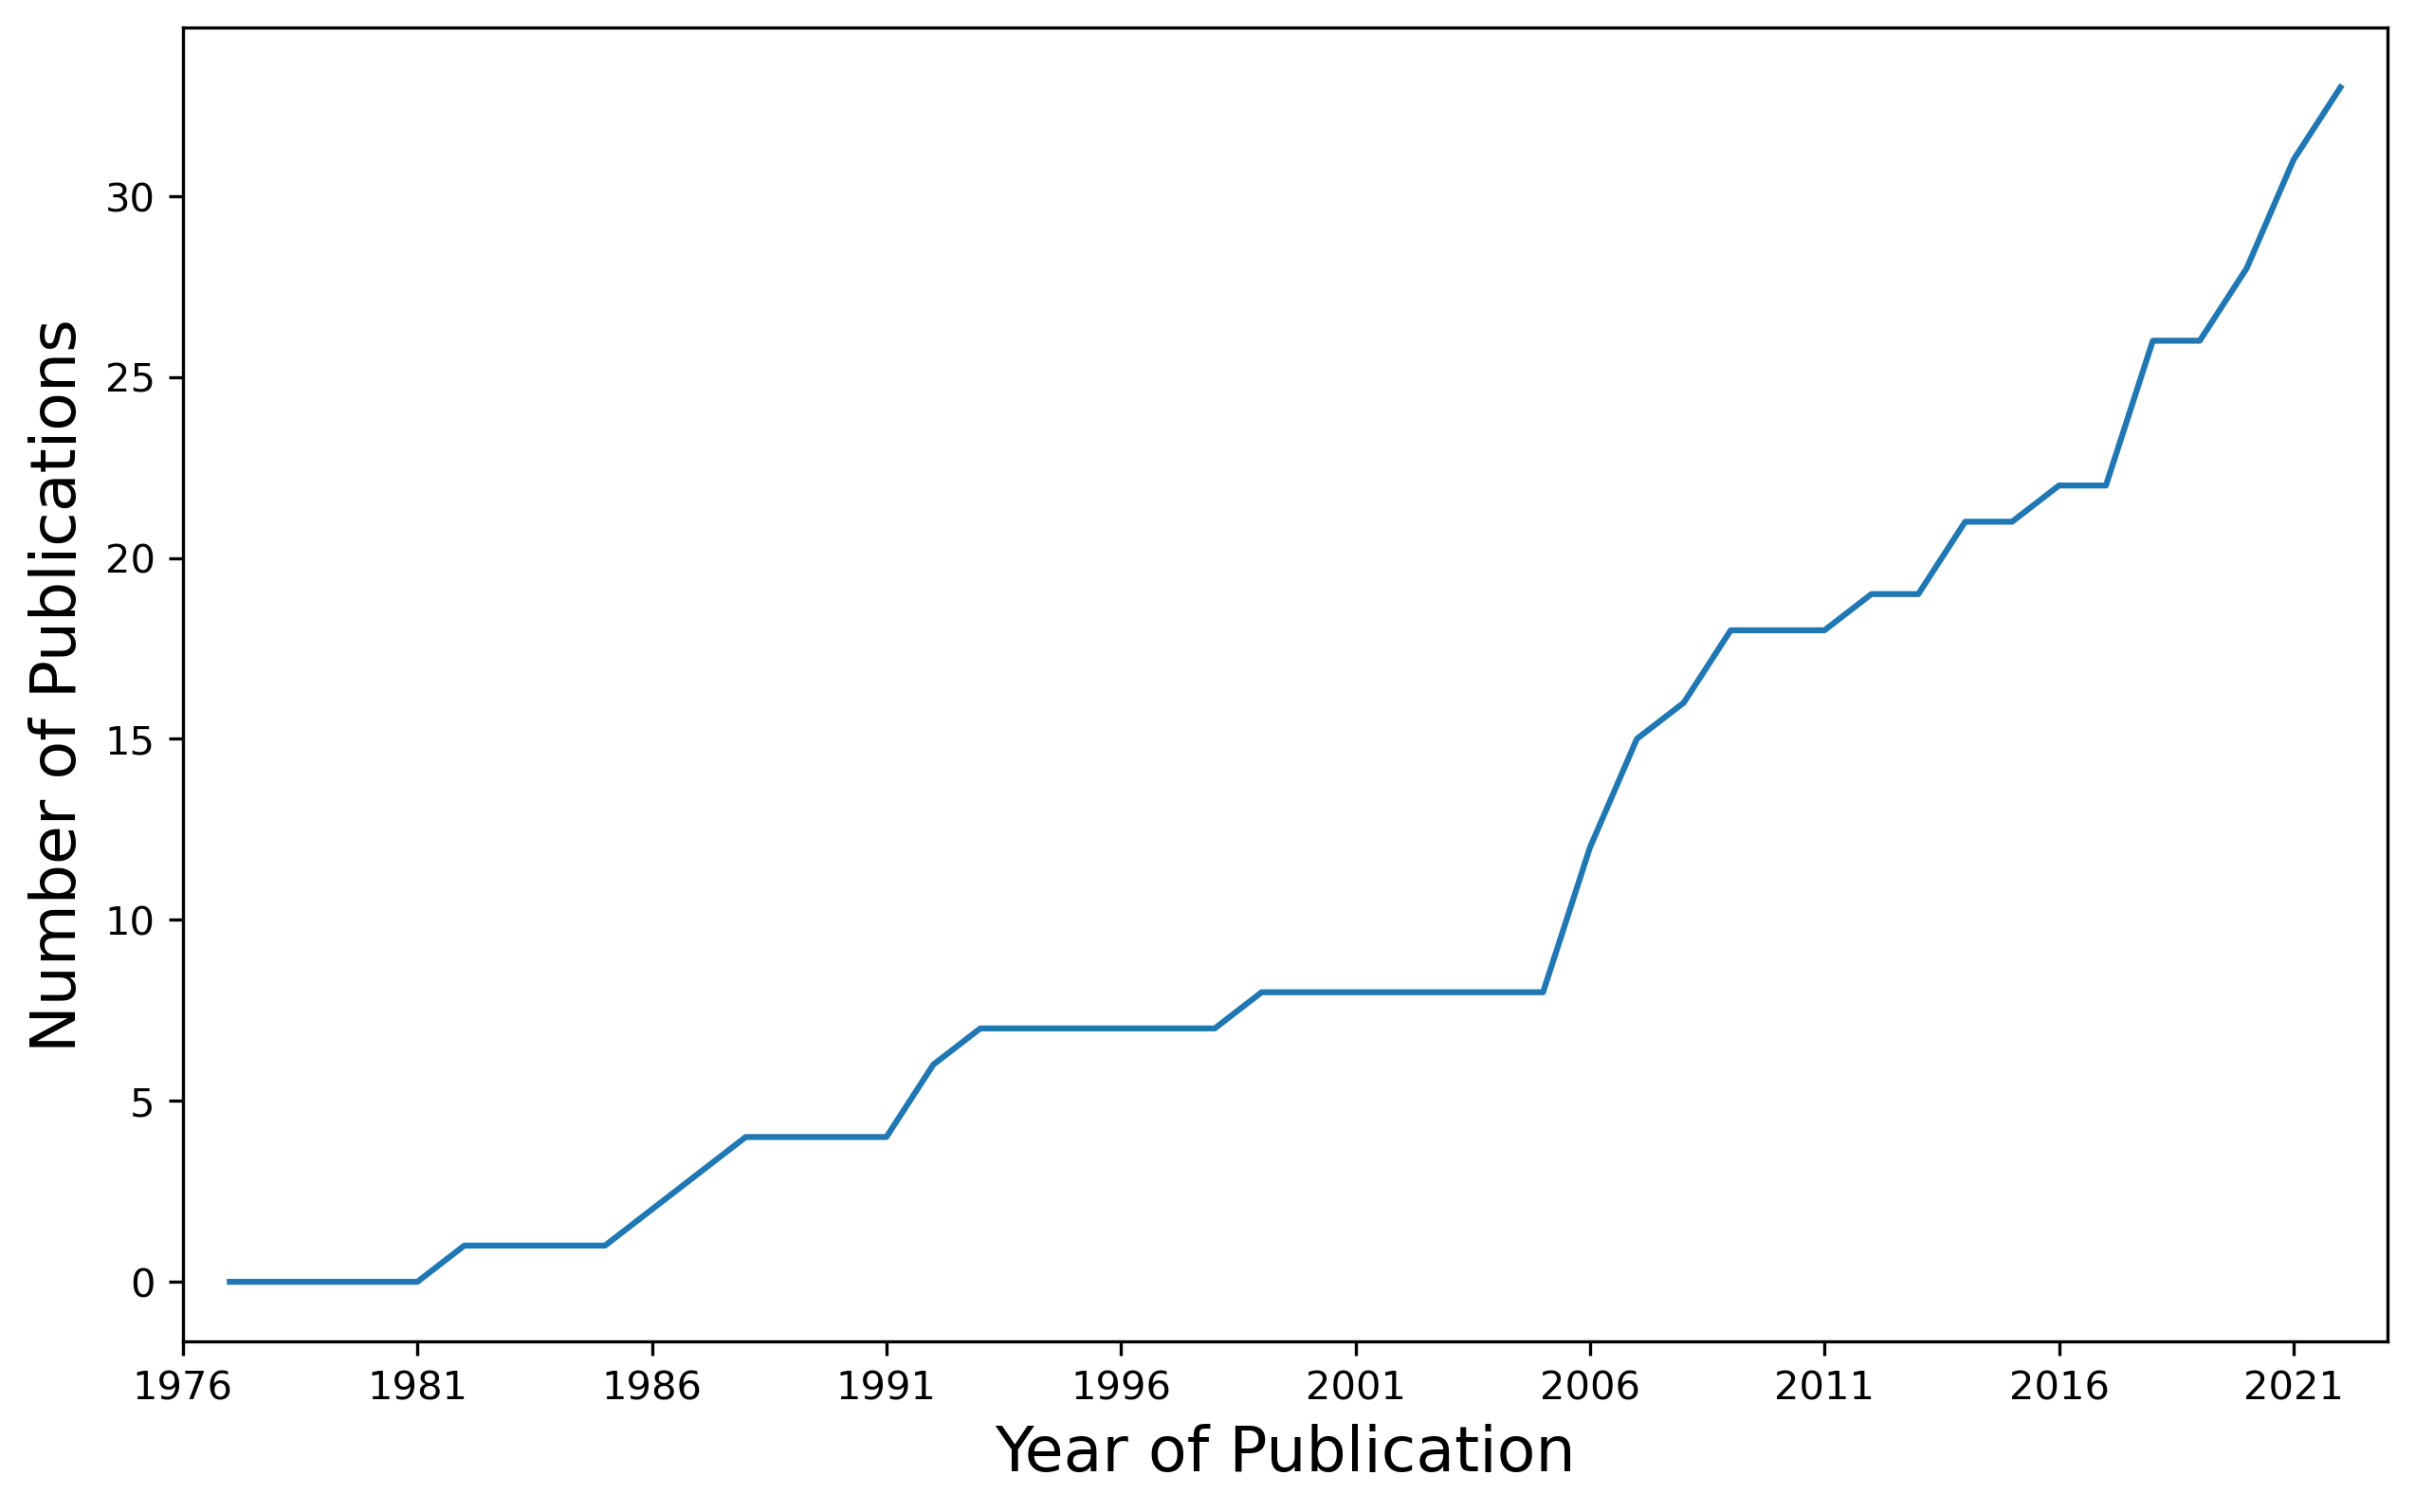

In [8]:
#graph on transportation in papers about maintenance
lookat = contain_values_M[(contain_values_M['Text'].str.contains(stemmer.stem("transportation")))]
lookatgroup = lookat.groupby("Year")["Year"].count().to_dict()

for i in range(1977,2023):
    if i not in lookatgroup:
        lookatgroup[i] = 0
        
mykeys = list(lookatgroup.keys())
mykeys.sort()
sorted_lookatgroup = {i: lookatgroup[i] for i in mykeys}

yearsar = list(sorted_lookatgroup.keys())
valuesar = list(sorted_lookatgroup.values())

updateddf = pd.DataFrame(data = {"Year": yearsar, "Number of Publications": valuesar})
updateddf["Cumulative Number"] = updateddf["Number of Publications"].cumsum() 

plt.figure(figsize=(10, 6), dpi = 300)

sns.lineplot(x="Year",y="Cumulative Number",data= updateddf)

plt.xlabel("Year of Publication", fontsize = 16)
plt.ylabel("Number of Publications", fontsize = 16)
#plt.title("Cumulative Number of EJOR Publications on Maintenance and Transportation")
plt.xlim(1976,2023)
plt.xticks(range(1976,2023,5))

plt.savefig(".\Graphs\CumulTransportation.jpg", format='jpeg', bbox_inches='tight')
plt.show()

## 2.6 Service contracts

In [44]:
lookat = contain_values_M[(contain_values_M['Text'].str.contains(stemmer.stem("contract"))) | (contain_values_M['Text'].str.contains(stemmer.stem("warranty")))]
lookat.to_excel(".\Interfaces\ServiceContracts.xlsx")

## 2.7 Environment

In [50]:
environment = contain_values_M[(contain_values_M['Text'].str.contains(stemmer.stem("environmental")))]
environment.to_excel(".\Interfaces\environment.xlsx")

## Plot interfaces

In [13]:
#function to make nice time series
def cleandf(lookat): 
    lookatgroup = lookat.groupby("Year")["Year"].count().to_dict()

    for i in range(1977,2024):
        if i not in lookatgroup:
            lookatgroup[i] = 0
        
    mykeys = list(lookatgroup.keys())
    mykeys.sort()
    sorted_lookatgroup = {i: lookatgroup[i] for i in mykeys}

    yearsar = list(sorted_lookatgroup.keys())
    valuesar = list(sorted_lookatgroup.values())

    updateddf = pd.DataFrame(data = {"Year": yearsar, "Number of Publications": valuesar})
    updateddf["Cumulative Number"] = updateddf["Number of Publications"].cumsum() 
    return updateddf

In [52]:
#3.1
Spareparts = pd.read_excel(".\Interfaces\SpareParts.xlsx")
Spareparts = cleandf(Spareparts)

#3.2
Production = pd.read_excel(".\Interfaces\Production.xlsx")
Production = Production[Production["correct"] == 1]
Production = cleandf(Production)

#3.3
Design = pd.read_excel(".\Interfaces\DesignMaintenance.xlsx")
Design = Design[Design["correct"] == 1]
Redundancy = pd.read_excel(".\Interfaces\RedundancyReliability.xlsx")
Designformaintenance = pd.concat([Design, Redundancy])

Designformaintenance = cleandf(Designformaintenance)

#3.4
Capacity = pd.read_excel(".\Interfaces\Capacity.xlsx")
Repair = pd.read_excel(".\Interfaces\Repair.xlsx")
Resource = pd.concat([Capacity, Repair])

Resource = cleandf(Resource)

#3.5
Transportation = pd.read_excel(".\Interfaces\Transportation.xlsx")
Transportation = cleandf(Transportation)

#3.6
ServiceContracts = pd.read_excel(".\Interfaces\ServiceContracts.xlsx")
ServiceContracts = ServiceContracts[ServiceContracts['correct'] == 1]
ServiceContracts = cleandf(ServiceContracts)

#3.7
Environment = pd.read_excel(".\Interfaces\environment.xlsx")
Environment = Environment[Environment['correct'] == 1]
Environment = cleandf(Environment)

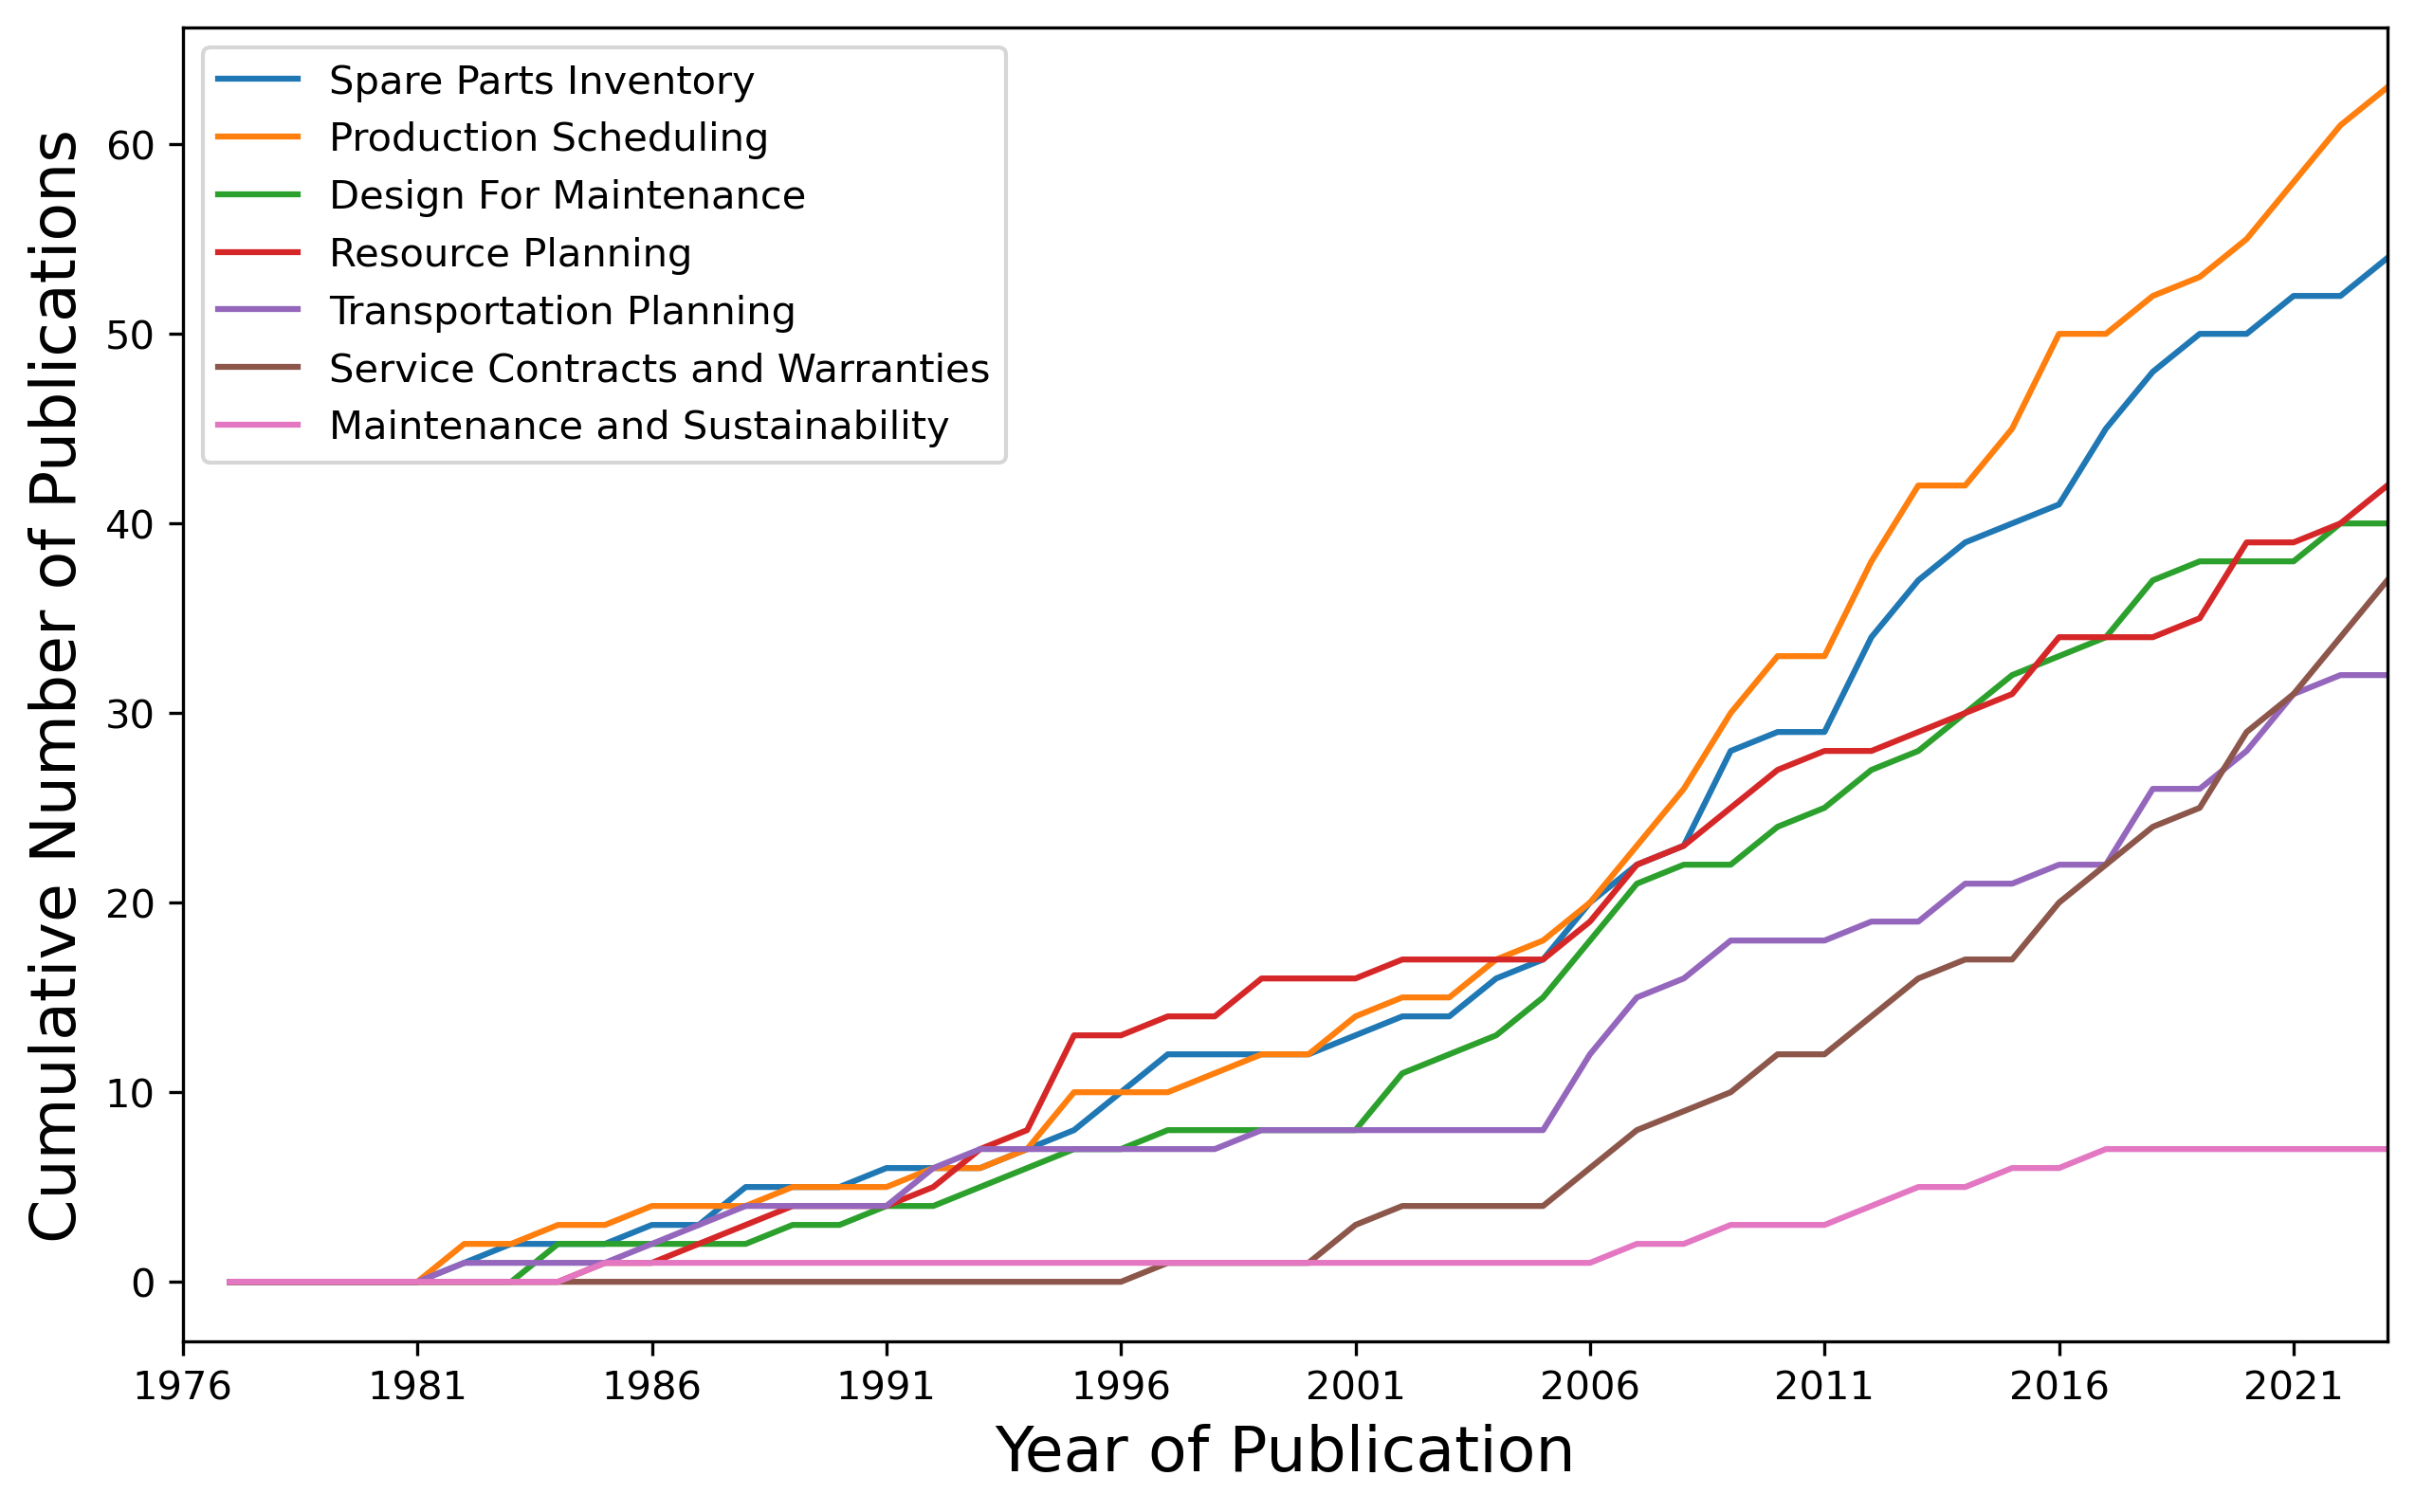

In [53]:
plt.figure(figsize=(10, 6), dpi = 300)

sns.lineplot(x="Year",y="Cumulative Number",data= Spareparts, label = "Spare Parts Inventory")
sns.lineplot(x="Year",y="Cumulative Number",data= Production, label = "Production Scheduling")
sns.lineplot(x="Year",y="Cumulative Number",data= Designformaintenance, label = "Design For Maintenance")
sns.lineplot(x="Year",y="Cumulative Number",data= Resource, label = "Resource Planning")
sns.lineplot(x="Year",y="Cumulative Number",data= Transportation, label = "Transportation Planning")
sns.lineplot(x="Year",y="Cumulative Number",data= ServiceContracts, label = "Service Contracts and Warranties")
sns.lineplot(x="Year",y="Cumulative Number",data= Environment, label = "Maintenance and Sustainability")

plt.xlabel("Year of Publication",fontsize=16)
plt.ylabel("Cumulative Number of Publications",fontsize = 16)
plt.xlim(1976,2023)
plt.xticks(range(1976,2023,5))
#plt.title("Cumulative Number of 'warranty', 'contract', or 'service' papers")

plt.savefig(".\Graphs\cumulinterface.jpg", format='jpeg', bbox_inches='tight')
plt.show()